<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task4_%E8%AE%BA%E6%96%87%E7%A7%8D%E7%B1%BB%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务介绍：
论文分类（数据建模任务），利用已有数据建模，对新论文进行类别分类；<br>
使用论文标题完成类别分类；<br>
学会文本分类的基本方法、TF-IDF等；<br>
TF-IDF（term frequency–inverse document frequency）<br>
TF是词频(Term Frequency)，IDF是逆文本频率指数(Inverse Document Frequency)。

## 数据处理步骤
在原始arxiv论文中论文都有对应的类别，而论文类别是作者填写的。在本次任务中我们可以借助论文的标题和摘要完成：<br>
+ 对论文标题和摘要进行处理；<br>
+ 对论文类别进行处理；<br>
+ 构建文本分类模型；<br>


## 文本分类方法
+ 1：TF-IDF+机器学习分类器
直接使用TF-IDF对文本提取特征，使用分类器进行分类，分类器的选择上可以使用SVM、LR、XGboost等。
+ 2：FastText
FastText是入门款的词向量，利用Facebook提供的FastText工具，可以快速构建分类器
+ 3：WordVec+深度学习分类器
WordVec是进阶款的词向量，并通过构建深度学习分类完成分类。深度学习分类的网络结构可以选择TextCNN、TextRnn或者BiLSTM。
+ 4：Bert词向量
Bert是高配款的词向量，具有强大的建模学习能力。

## 代码实现

### 加载数据

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') #挂载google drive 加载数据集

Mounted at /content/gdrive/


In [ ]:
!cp -f  /content/gdrive/MyDrive/Colab\ Notebooks/arxiv.zip  /content/ 

In [ ]:
!unzip -o /content/arxiv.zip  #解压数据集

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


### 导入所需的数据包

In [ ]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

### 读取所有数据

In [ ]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json', 
                     ['id', 'title', 'categories', 'abstract'],200000)

In [ ]:
data 

,id,title,categories,abstract
0,0704.0001,Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...
1,0704.0002,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-..."
2,0704.0003,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...
3,0704.0004,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...
...,...,...,...,...
199995,1007.0757,Detectability of large-scale power suppression...,astro-ph.CO gr-qc hep-th,Suppression in primordial power on the Unive...
199996,1007.0758,Systematic Improvement of Parton Showers with ...,hep-ph hep-ex nucl-th,We carry out a systematic classification and...
199997,1007.0759,Relaxation dynamics of stochastic long-range i...,cond-mat.stat-mech,"Long-range interacting systems, while relaxi..."
199998,1007.0760,Identification of a connection from Cauchy dat...,math.DG math.AP,We consider a connection $\nabla^X$ on a com...


### 将标题和摘要拼接一起

In [ ]:
data['text'] = data['title'] + data['abstract']

In [ ]:
data.head()

,id,title,categories,abstract,text
0,0704.0001,Calculation of prompt diphoton production cros...,hep-ph,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...
1,0704.0002,Sparsity-certifying Graph Decompositions,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions We d...
2,0704.0003,The evolution of the Earth-Moon system based o...,physics.gen-ph,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...
3,0704.0004,A determinant of Stirling cycle numbers counts...,math.CO,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...


In [ ]:
data['text'] = data['text'].apply(lambda x: x.replace('\n',' '))
data['text'] = data['text'].apply(lambda x: x.lower())
data = data.drop(['abstract', 'title'], axis=1)

In [ ]:
data

,id,categories,text
0,0704.0001,hep-ph,calculation of prompt diphoton production cros...
1,0704.0002,math.CO cs.CG,sparsity-certifying graph decompositions we d...
2,0704.0003,physics.gen-ph,the evolution of the earth-moon system based o...
3,0704.0004,math.CO,a determinant of stirling cycle numbers counts...
4,0704.0005,math.CA math.FA,from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...
...,...,...,...
199995,1007.0757,astro-ph.CO gr-qc hep-th,detectability of large-scale power suppression...
199996,1007.0758,hep-ph hep-ex nucl-th,systematic improvement of parton showers with ...
199997,1007.0759,cond-mat.stat-mech,relaxation dynamics of stochastic long-range i...
199998,1007.0760,math.DG math.AP,identification of a connection from cauchy dat...


### 处理类别

In [ ]:
# 多个类别，包含子分类
data['categories'] = data['categories'].apply(lambda x : x.split(' '))


In [ ]:
data

,id,categories,text
0,0704.0001,[hep-ph],calculation of prompt diphoton production cros...
1,0704.0002,"[math.CO, cs.CG]",sparsity-certifying graph decompositions we d...
2,0704.0003,[physics.gen-ph],the evolution of the earth-moon system based o...
3,0704.0004,[math.CO],a determinant of stirling cycle numbers counts...
4,0704.0005,"[math.CA, math.FA]",from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...
...,...,...,...
199995,1007.0757,"[astro-ph.CO, gr-qc, hep-th]",detectability of large-scale power suppression...
199996,1007.0758,"[hep-ph, hep-ex, nucl-th]",systematic improvement of parton showers with ...
199997,1007.0759,[cond-mat.stat-mech],relaxation dynamics of stochastic long-range i...
199998,1007.0760,"[math.DG, math.AP]",identification of a connection from cauchy dat...


In [ ]:
# 单个类别，不包含子分类
data['categories_big'] = data['categories'].apply(lambda x : [xx.split('.')[0] for xx in x])

In [ ]:
data

,id,categories,text,categories_big
0,0704.0001,[hep-ph],calculation of prompt diphoton production cros...,[hep-ph]
1,0704.0002,"[math.CO, cs.CG]",sparsity-certifying graph decompositions we d...,"[math, cs]"
2,0704.0003,[physics.gen-ph],the evolution of the earth-moon system based o...,[physics]
3,0704.0004,[math.CO],a determinant of stirling cycle numbers counts...,[math]
4,0704.0005,"[math.CA, math.FA]",from dyadic $\lambda_{\alpha}$ to $\lambda_{\a...,"[math, math]"
...,...,...,...,...
199995,1007.0757,"[astro-ph.CO, gr-qc, hep-th]",detectability of large-scale power suppression...,"[astro-ph, gr-qc, hep-th]"
199996,1007.0758,"[hep-ph, hep-ex, nucl-th]",systematic improvement of parton showers with ...,"[hep-ph, hep-ex, nucl-th]"
199997,1007.0759,[cond-mat.stat-mech],relaxation dynamics of stochastic long-range i...,[cond-mat]
199998,1007.0760,"[math.DG, math.AP]",identification of a connection from cauchy dat...,"[math, math]"


使用sklearn对类别进行编码

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
data_label = mlb.fit_transform(data['categories_big'].iloc[:])

In [ ]:
data_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

方法一
使用TFIDF提取特征，限制最多4000个单词：<br>
1.datawhale 教程方法

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=4000)
data_tfidf = vectorizer.fit_transform(data['text'].iloc[:])

In [ ]:
# 划分训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_tfidf, data_label,test_size = 0.2,random_state = 16)

TF-IDF+ 朴素贝叶斯

In [ ]:
# 用sklearn构建多标签分类模型
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB  # 朴素贝叶斯多分类器
clf = MultiOutputClassifier(MultinomialNB()).fit(x_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
##计算模型的准确率
print(clf.score(x_train,y_train))
print('训练数据集准确率',accuracy_score(y_train,clf.predict(x_train)))
print(clf.score(x_test,y_test))
print('测试集准确率',accuracy_score(y_test,clf.predict(x_test)))

0.57288125
训练数据集准确率 0.57288125
0.56925
测试集准确率 0.56925


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.84      0.90      7756
           1       0.85      0.79      0.82      7392
           2       0.75      0.73      0.74      2891
           3       0.00      0.00      0.00         1
           4       0.72      0.48      0.57      2128
           5       0.47      0.67      0.55       905
           6       0.93      0.36      0.52       563
           7       0.71      0.68      0.69      3601
           8       0.75      0.60      0.67      3425
           9       0.85      0.88      0.87     10945
          10       0.46      0.12      0.19      1835
          11       0.79      0.05      0.10       724
          12       0.47      0.37      0.41       523
          13       0.55      0.37      0.44      1103
          14       0.67      0.14      0.23      3392
          15       0.77      0.17      0.27       653
          16       0.91      0.16      0.27       260
          17       0.89    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TF-IDF+LR

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
clf1 = OneVsRestClassifier(LogisticRegression(),n_jobs=-1).fit(x_train, y_train)

In [ ]:
##计算模型的准确率
print(clf1.score(x_train,y_train))
print('训练数据集准确率(KNN)',accuracy_score(y_train,clf1.predict(x_train)))
print(clf1.score(x_test,y_test))
print('测试集准确率(KNN)',accuracy_score(y_test,clf1.predict(x_test)))

0.66745
训练数据集准确率(KNN) 0.66745
0.64945
测试集准确率(KNN) 0.64945


In [ ]:
print(classification_report(y_test, clf1.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7756
           1       0.90      0.82      0.86      7392
           2       0.86      0.71      0.78      2891
           3       0.00      0.00      0.00         1
           4       0.77      0.58      0.66      2128
           5       0.80      0.51      0.63       905
           6       0.90      0.58      0.71       563
           7       0.83      0.68      0.75      3601
           8       0.81      0.61      0.69      3425
           9       0.91      0.88      0.90     10945
          10       0.57      0.12      0.20      1835
          11       0.70      0.22      0.33       724
          12       0.67      0.34      0.46       523
          13       0.80      0.46      0.59      1103
          14       0.69      0.35      0.47      3392
          15       0.79      0.39      0.52       653
          16       0.88      0.40      0.55       260
          17       0.86    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TF-IDF+线性支持向量机 
svc

In [ ]:
from sklearn.svm import LinearSVC
clf2 = OneVsRestClassifier(LinearSVC(), n_jobs=1).fit(x_train, y_train)

In [ ]:
##计算模型的准确率
print(clf2.score(x_train,y_train))
print('训练数据集准确率(KNN)',accuracy_score(y_train,clf2.predict(x_train)))
print(clf2.score(x_test,y_test))
print('测试集准确率(KNN)',accuracy_score(y_test,clf2.predict(x_test)))

0.70023125
训练数据集准确率(KNN) 0.70023125
0.66015
测试集准确率(KNN) 0.66015


In [ ]:
print(classification_report(y_test, clf1.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      7756
           1       0.90      0.82      0.86      7392
           2       0.86      0.71      0.78      2891
           3       0.00      0.00      0.00         1
           4       0.77      0.58      0.66      2128
           5       0.80      0.51      0.63       905
           6       0.90      0.58      0.71       563
           7       0.83      0.68      0.75      3601
           8       0.81      0.61      0.69      3425
           9       0.91      0.88      0.90     10945
          10       0.57      0.12      0.20      1835
          11       0.70      0.22      0.33       724
          12       0.67      0.34      0.46       523
          13       0.80      0.46      0.59      1103
          14       0.69      0.35      0.47      3392
          15       0.79      0.39      0.52       653
          16       0.88      0.40      0.55       260
          17       0.86    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


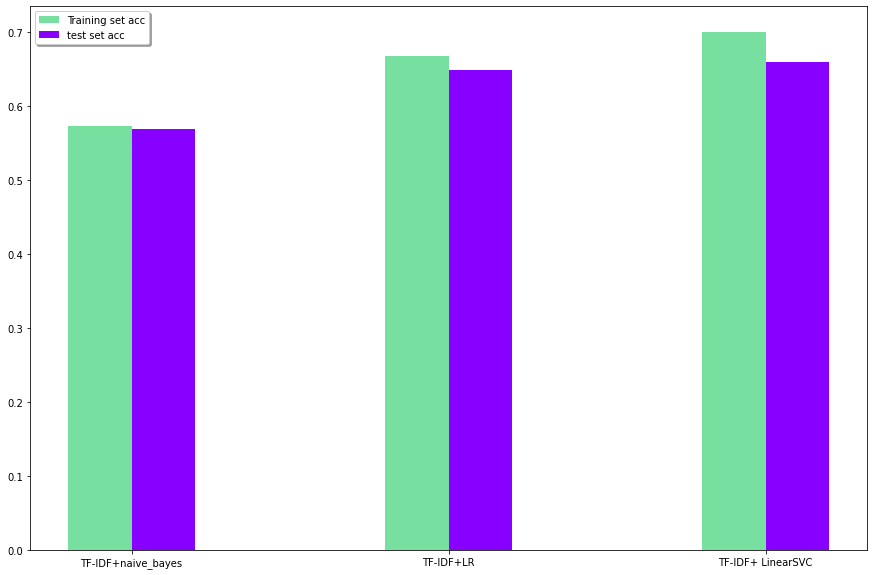

In [ ]:
import numpy as np

plt.figure(figsize=(15, 10), facecolor='w')
x = np.arange(3)
training_acc = [clf.score(x_train,y_train),clf1.score(x_train,y_train),clf2.score(x_train,y_train)]
test_acc = [clf.score(x_test,y_test),clf1.score(x_test,y_test),clf2.score(x_test,y_test)]
clf_names = ["TF-IDF+naive_bayes","TF-IDF+LR","TF-IDF+ LinearSVC"]
ax = plt.axes()
b0 = ax.bar(x+0.1, training_acc, width=0.2, color='#77E0A0')
b1 = ax.bar(x+0.3, test_acc, width=0.2, color='#8800FF')
plt.xticks(x+0.2, clf_names)
plt.legend([b0[0], b1[0]], (u'Training set acc', u'test set acc'), loc='upper left', shadow=True)
plt.show()

## 方法2 深度学习

In [62]:
# parameter
max_features= 500
max_len= 150
embed_size=100
batch_size = 32
epochs = 5

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence



In [69]:
tokens = Tokenizer(num_words = max_features)
tokens.fit_on_texts(list(data['text']))
y_train = data_label
#y_test = data_label[180000:]
x_sub_train = tokens.texts_to_sequences(data['text'])
x_sub_train = sequence.pad_sequences(x_sub_train, maxlen=max_len)
# x_sub_test = tokens.texts_to_sequences(data['text'].iloc[180000:])
# x_sub_test = sequence.pad_sequences(x_sub_test, maxlen=max_len)

In [70]:
# LSTM model
# Keras Layers:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D# Keras Callback Functions:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.models import Model
from keras.optimizers import Adam

sequence_input = Input(shape=(max_len, ))
x = Embedding(max_features, embed_size, trainable=True)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(19, activation="sigmoid")(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
model.fit(x_sub_train, y_train, 
          batch_size=batch_size, 
          validation_split=0.2,
          epochs=epochs)

Epoch 1/5
5000/5000 [==============================] - 3203s 640ms/step - loss: 0.1422 - accuracy: 0.5925 - val_loss: 0.1050 - val_accuracy: 0.7135
Epoch 2/5
5000/5000 [==============================] - 3242s 648ms/step - loss: 0.0989 - accuracy: 0.7089 - val_loss: 0.0991 - val_accuracy: 0.7290
Epoch 3/5
5000/5000 [==============================] - 3205s 641ms/step - loss: 0.0929 - accuracy: 0.7241 - val_loss: 0.0983 - val_accuracy: 0.7237
Epoch 4/5
5000/5000 [==============================] - 3224s 645ms/step - loss: 0.0900 - accuracy: 0.7309 - val_loss: 0.0959 - val_accuracy: 0.7329
Epoch 5/5
5000/5000 [==============================] - 3158s 632ms/step - loss: 0.0865 - accuracy: 0.7400 - val_loss: 0.0950 - val_accuracy: 0.7336
